In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cifake-real-and-ai-generated-synthetic-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3041726%2F5256696%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240601%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240601T000142Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1775cb17c75088711c096a67c07c34ece03cf85f3dff67d6289891684631a219794b1505a6be1a695b761d271530d883aa868821032ce2cae95a5c125092f5599c31794db8fa4af4f48f52176344052b35c961b7f855be9311b5d11d297880c2592bc551778e8a6265ad3372b428084830ee9d3536e64b4ea7f0601ce3a6c17d5a9d3767dc758a1bf09d6976e4ccb12b3a06d81b492584c6f33130be74d4aaf2529166b7934e2a6fcbff3694328858213c725d0e0577eac9f1236ec05d7a1762aa19032c4ea91d0747a9eb1b3e2ebee13dc01d8d01bb9f51853a1ce54291a35527fc47532285984b4000835267094b358050021ea9440d1daa10412ffd4b5ff5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


OSError: [WinError 1314] A required privilege is not held by the client: '/kaggle/input' -> '..\\input'

## Fine-tuning CNN for AI-generated Image Detection
In this notebook, we will explore the task of classifying images as real or AI-generated using fine-tuning techniques with several well-known CNN architectures. For this classification task, we will use the CIFAKE dataset, which includes both real and AI-generated images.

Link for the dataset: [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

In [3]:
dataset_dir = "../Datasets/archive/" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: ../Datasets/archive/


In [4]:
# Check if GPUs are available for training
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


Larger batch sizes are expected to result in significantly longer training times, especially with a substantial training set of 100,000 images. However, the compact size of the images effectively reduces the impact on training duration.

In [6]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# Constant values that will be shared by all the models
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [21]:
labels = train_ds.class_names
print(labels)

['FAKE', 'REAL']


### Model Building

All the models share the same architecture for a fair comparison: the input layer, followed by the base model with pre-trained weights from the imagenet, then a few dense layers, and then a unit output with a sigmoid activation function.

Training is conducted with early stopping criteria monitoring the validation loss, and the best weights will be restored once the training is completed.

In [15]:
# Building the Transfer Learning model using ResNet50
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
ResNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = ResNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256,
          kernel_regularizer = regularizers.l2(0.01),
          activity_regularizer = regularizers.l1(0.01),
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
ResNet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448  

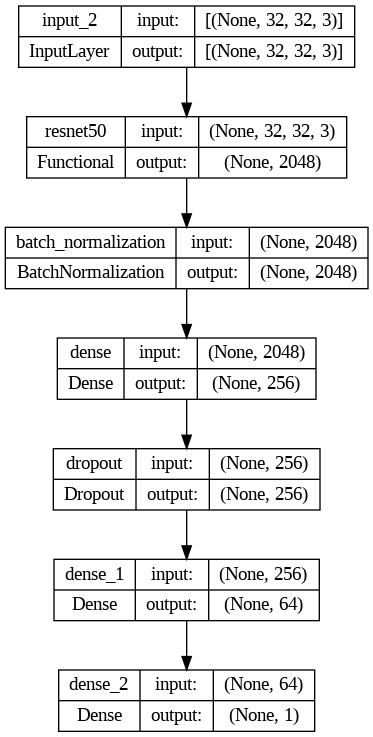

In [16]:
# Visualize the ResNet model architecture
tf.keras.utils.plot_model(ResNet_model, show_shapes = True, to_file = 'ResNet_model.png')
Image('ResNet_model.png')

In [17]:
# Train the Transfer Learning model
print("Starting training with Transfer Learning using ResNet50...")
ResNet_model_history = ResNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using ResNet50...
Epoch 1/100
200/200 [==============================] - 86s 199ms/step - loss: 1.6978 - accuracy: 0.9105 - precision: 0.9103 - recall: 0.9109 - val_loss: 0.8732 - val_accuracy: 0.8196 - val_precision: 0.9914 - val_recall: 0.6449
Epoch 2/100
200/200 [==============================] - 39s 193ms/step - loss: 0.3817 - accuracy: 0.9460 - precision: 0.9468 - recall: 0.9450 - val_loss: 0.4474 - val_accuracy: 0.8586 - val_precision: 0.9941 - val_recall: 0.7215
Epoch 3/100
200/200 [==============================] - 41s 201ms/step - loss: 0.2040 - accuracy: 0.9565 - precision: 0.9572 - recall: 0.9558 - val_loss: 0.2980 - val_accuracy: 0.8822 - val_precision: 0.9951 - val_recall: 0.7682
Epoch 4/100
200/200 [==============================] - 41s 201ms/step - loss: 0.1560 - accuracy: 0.9627 - precision: 0.9642 - recall: 0.9611 - val_loss: 0.1528 - val_accuracy: 0.9563 - val_precision: 0.9577 - val_recall: 0.9547
Epoch 5/100
200/200 [========

In [18]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = ResNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 2s 45ms/step - loss: 0.1431 - accuracy: 0.9575 - precision: 0.9592 - recall: 0.9556
Val Loss: 0.1431
Val Accuracy: 0.9575
Val Precision: 0.9592
Val Recall: 0.9556


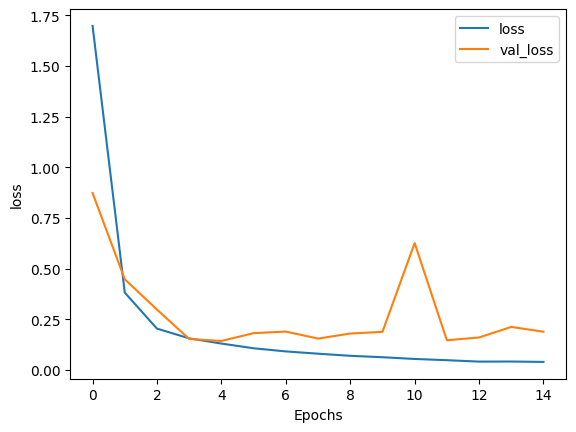

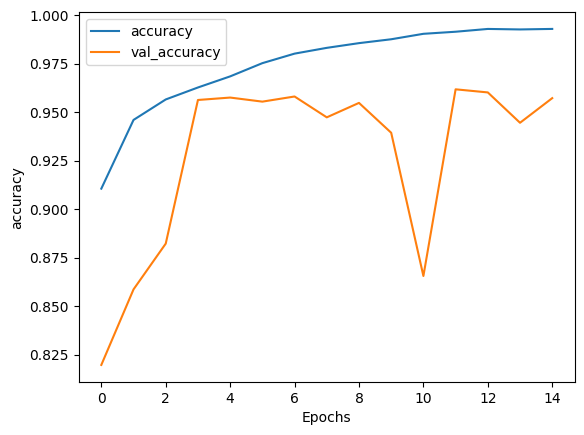

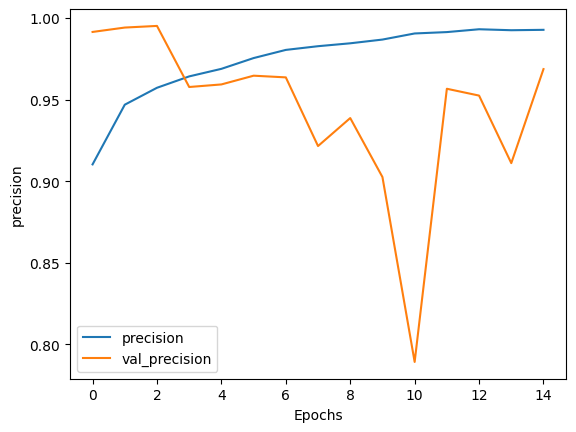

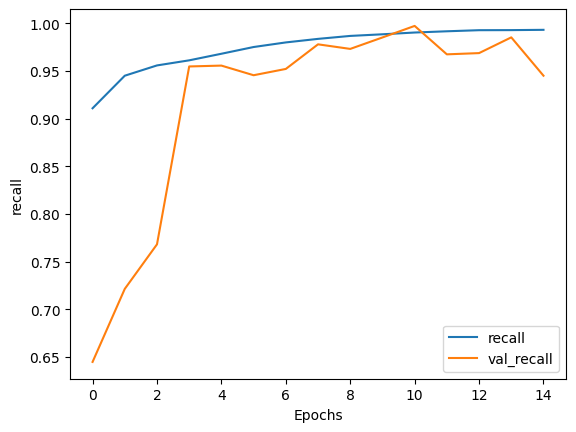

In [19]:
# Plot error rates and metric rates
plot_metrics(ResNet_model_history, 'loss')
plot_metrics(ResNet_model_history, 'accuracy')
plot_metrics(ResNet_model_history, 'precision')
plot_metrics(ResNet_model_history, 'recall')

In [20]:
ResNet_model.save('restnet_model_h5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('restnet_model_h5.h5')

/kaggle/working


/kaggle/working/restnet_model_h5.h5

In [22]:
# Building the Transfer Learning model using VGG16
VGG_base_model = tf.keras.applications.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
VGG_base_model.trainable = True

# Create a new model on top of the VGG16 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = VGG_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256,
          kernel_regularizer = regularizers.l2(0.01),
          activity_regularizer = regularizers.l1(0.01),
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
VGG_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
VGG_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
VGG_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448

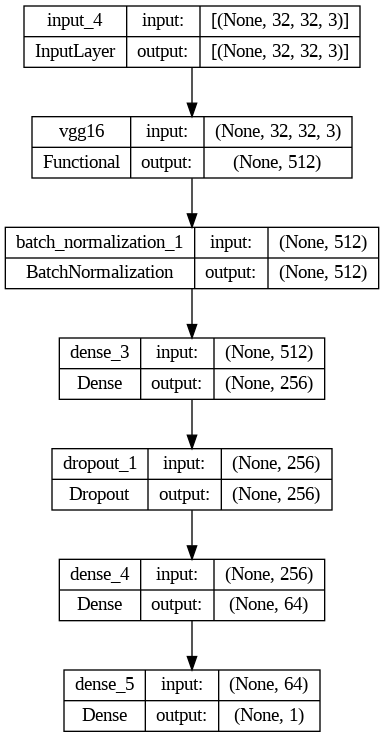

In [23]:
# Visualize the VGG model architecture
tf.keras.utils.plot_model(VGG_model, show_shapes = True, to_file = 'VGG_model.png')
Image('VGG_model.png')

In [24]:
print("Starting training with Transfer Learning using VGG16...")
VGG_model_history = VGG_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using VGG16...
Epoch 1/100
200/200 [==============================] - 51s 175ms/step - loss: 1.5322 - accuracy: 0.8460 - precision_1: 0.8309 - recall_1: 0.8687 - val_loss: 1.0717 - val_accuracy: 0.6512 - val_precision_1: 0.5892 - val_recall_1: 0.9985
Epoch 2/100
200/200 [==============================] - 35s 172ms/step - loss: 0.4047 - accuracy: 0.9316 - precision_1: 0.9297 - recall_1: 0.9339 - val_loss: 0.5754 - val_accuracy: 0.7648 - val_precision_1: 0.6808 - val_recall_1: 0.9971
Epoch 3/100
200/200 [==============================] - 35s 174ms/step - loss: 0.2293 - accuracy: 0.9471 - precision_1: 0.9470 - recall_1: 0.9471 - val_loss: 0.4503 - val_accuracy: 0.8165 - val_precision_1: 0.7327 - val_recall_1: 0.9966
Epoch 4/100
200/200 [==============================] - 35s 172ms/step - loss: 0.1692 - accuracy: 0.9572 - precision_1: 0.9577 - recall_1: 0.9567 - val_loss: 0.1701 - val_accuracy: 0.9533 - val_precision_1: 0.9538 - val_recall_1: 0.9527


In [25]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = VGG_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 2s 50ms/step - loss: 0.1252 - accuracy: 0.9611 - precision_1: 0.9476 - recall_1: 0.9762
Val Loss: 0.1252
Val Accuracy: 0.9611
Val Precision: 0.9476
Val Recall: 0.9762


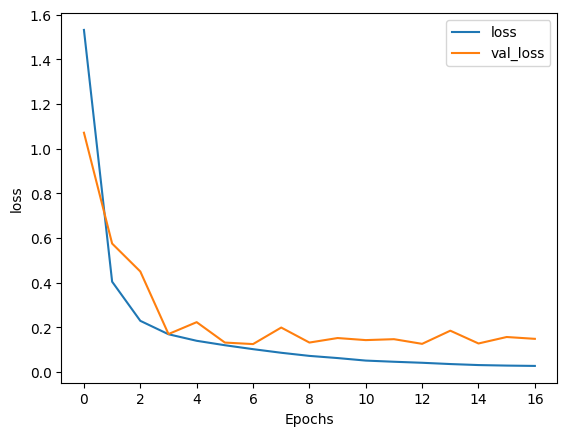

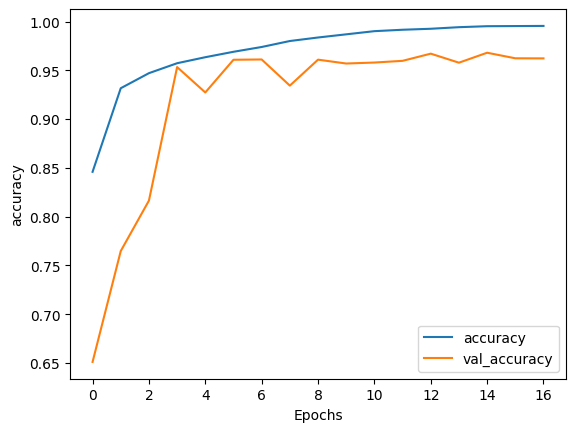

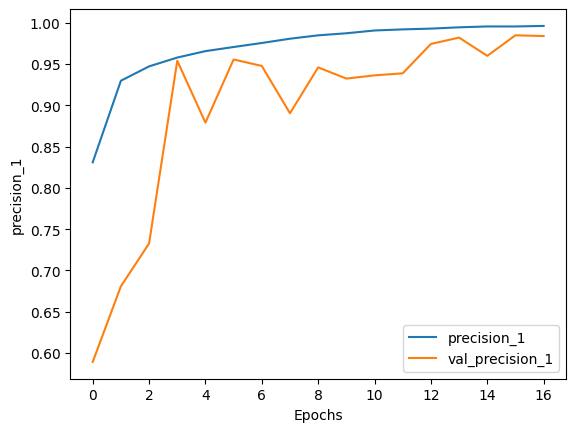

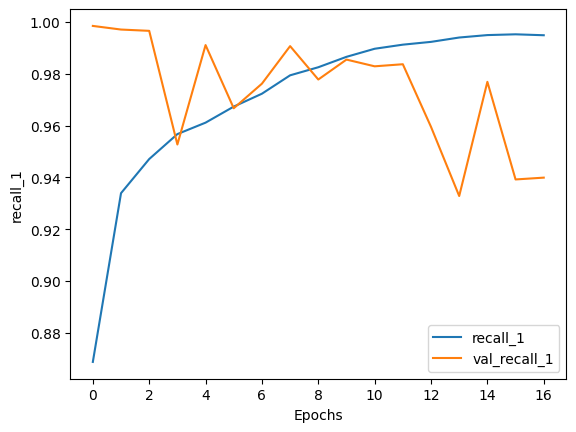

In [26]:
# Plot error rates and metric rates
plot_metrics(VGG_model_history, 'loss')
plot_metrics(VGG_model_history, 'accuracy')
plot_metrics(VGG_model_history, 'precision_1')
plot_metrics(VGG_model_history, 'recall_1')

In [27]:
VGG_model.save('VGG_model_h5.h5')

In [28]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('VGG_model_h5.h5')

/kaggle/working


/kaggle/working/VGG_model_h5.h5

In [7]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256,
          kernel_regularizer = regularizers.l2(0.01),
          activity_regularizer = regularizers.l1(0.01),
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()



24274472/24274472 [==============================] - 5s 0us/step

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                           

In [ ]:
# Visualize the EfficientNet model architecture
tf.keras.utils.plot_model(EfficientNet_model, show_shapes = True, to_file = 'EfficientNet_model.png')
Image('EfficientNet_model.png')

In [ ]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using EfficientNet...")
EfficientNet_model_history = EfficientNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

In [ ]:
import pandas as pd

# Get the predicted labels for the test dataset
predictions = ResNet_model.predict(val_ds)

# Convert the predicted labels to binary values (0 or 1)
predicted_value = [pred for pred in predictions]
predicted_labels = [1 if pred >= 0.5 else 0 for pred in predictions]

# Get the image names from the test dataset
image_names = val_ds.file_paths

# Get the original labels from the test dataset
original_labels = val_true_classes

# Create a DataFrame with the image names, predicted labels, and original labels
df = pd.DataFrame({'Image Name': image_names, 'Predicted Label': predicted_labels, 'Original Label': original_labels})

# Save the DataFrame as a CSV file
df.to_csv('predictions.csv', index=False)

In [ ]:
# Select a specific image from the test dataset
image_index = 0  # Change this to the desired index of the image you want to predict
image_data, true_label = next(iter(val_ds.skip(image_index).take(1)))

# Make the prediction using the EfficientNet_model
prediction = EfficientNet_model.predict(image_data)

# Convert the prediction to a class label
predicted_class = class_names[int(prediction[0][0] > 0.5)]

# Print the predicted class and true label
print("Predicted class:", predicted_class)
print("True label:", class_names[int(true_label[0])])

In [ ]:
from PIL import Image
import numpy as np

# Upload the image file and save it to a local directory
uploaded_file = 'path/to/uploaded/image.jpg'

# Read the image file using PIL
img = Image.open(uploaded_file)

# Preprocess the image
img = img.resize((img_height, img_width))  # Resize the image to match the model's input size
img_array = np.array(img) / 255.0  # Normalize the pixel values to the range [0, 1]

# Reshape the image array to match the expected input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Make predictions using the model
prediction = ResNet_model.predict(img_array)

# Get the predicted class
predicted_class = class_names[int(np.round(prediction[0][0]))]

# Display the predicted class
print("Predicted class:", predicted_class)

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
# model = tf.keras.models.load_model('restnet_model_h5.h5')

# get image from file upload
img = image.load_img('851 (9).jpg', target_size=(32, 32))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array = img_array / 255.0  # Normalize the image

# Make the prediction
prediction = EfficientNet_model.predict(img_array)
print(prediction)
predicted_class = class_names[int(prediction[0][0])]

print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 52ms/step
[[0.22370607]]
Predicted class: FAKE


In [32]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 3s 58ms/step - loss: 0.1131 - accuracy: 0.9756 - precision_2: 0.9800 - recall_2: 0.9710
Val Loss: 0.1131
Val Accuracy: 0.9756
Val Precision: 0.9800
Val Recall: 0.9710


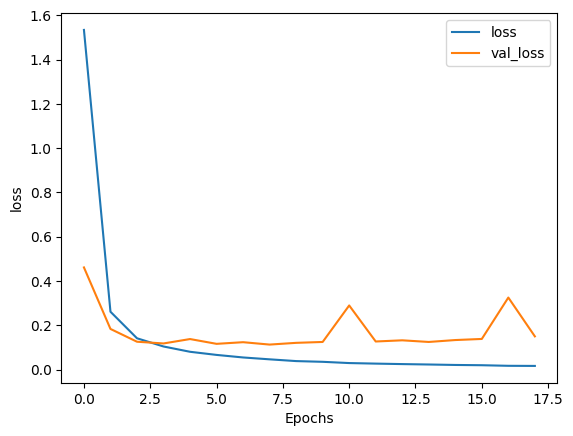

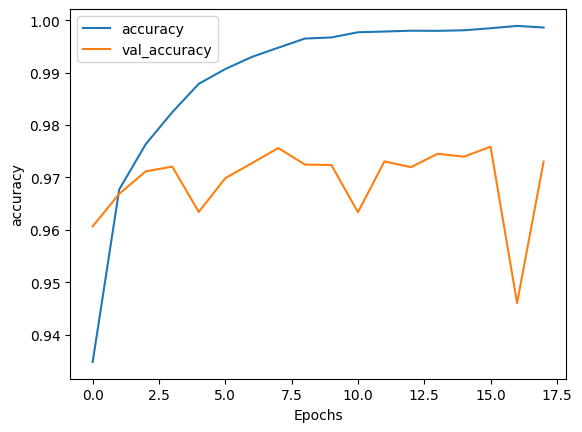

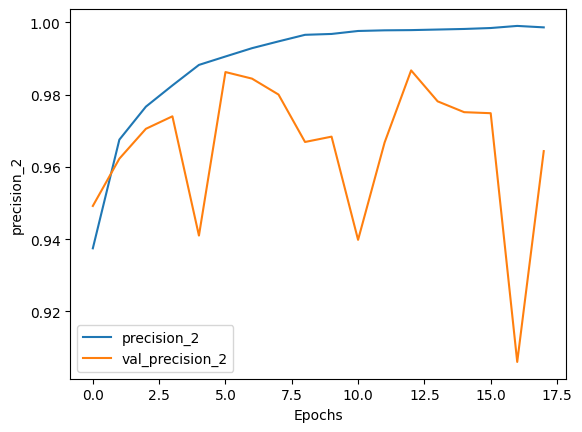

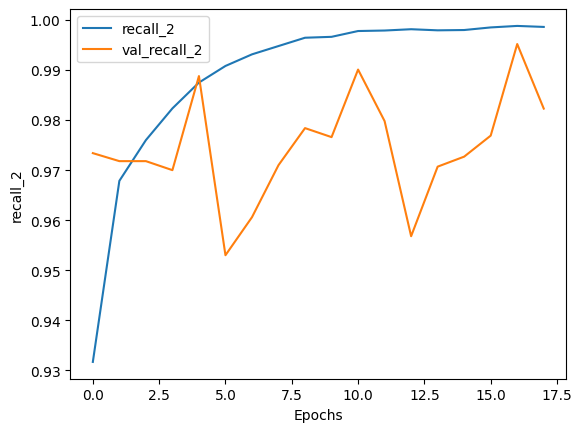

In [33]:
# Plot error rates and metric rates
plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')
plot_metrics(EfficientNet_model_history, 'precision_2')
plot_metrics(EfficientNet_model_history, 'recall_2')

In [7]:
# Save the EfficientNet model
EfficientNet_model.save("EfficientNet_model.h5")

NameError: name 'EfficientNet_model' is not defined

In [43]:
from google.colab import files
files.download('EfficientNet_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
# Building the Transfer Learning model using MobileNetV3
MobileNet_base_model = tf.keras.applications.MobileNetV3Small(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
MobileNet_base_model.trainable = True

# Create a new model on top of the MobileNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = MobileNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256,
          kernel_regularizer = regularizers.l2(0.01),
          activity_regularizer = regularizers.l1(0.01),
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
MobileNet_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
MobileNet_model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 batch_normalization_3 (Bat  (None, 576)               2304      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 256)               147712    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                              

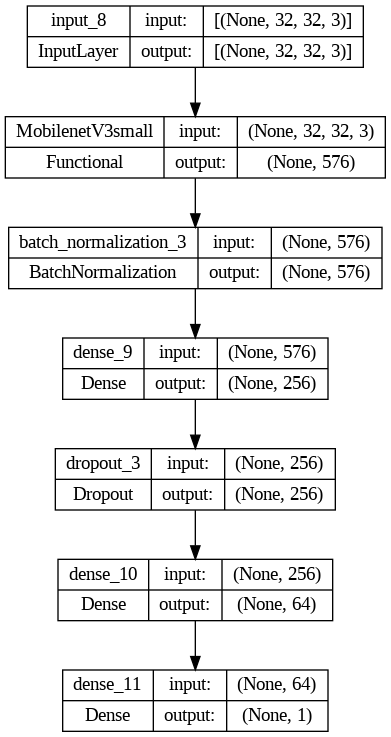

In [36]:
# Visualize the MobileNet model architecture
tf.keras.utils.plot_model(MobileNet_model, show_shapes = True, to_file = 'MobileNet_model.png')
Image('MobileNet_model.png')

In [37]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using MobileNet...")
MobileNet_model_history = MobileNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using MobileNet...
Epoch 1/100
200/200 [==============================] - 51s 122ms/step - loss: 1.3272 - accuracy: 0.5018 - precision_3: 0.5020 - recall_3: 0.4329 - val_loss: 0.6947 - val_accuracy: 0.5000 - val_precision_3: 0.5000 - val_recall_3: 1.0000
Epoch 2/100
200/200 [==============================] - 23s 114ms/step - loss: 0.6936 - accuracy: 0.4999 - precision_3: 0.4999 - recall_3: 0.5199 - val_loss: 0.6935 - val_accuracy: 0.5000 - val_precision_3: 0.5000 - val_recall_3: 1.0000
Epoch 3/100
200/200 [==============================] - 23s 114ms/step - loss: 0.6936 - accuracy: 0.4988 - precision_3: 0.4990 - recall_3: 0.5988 - val_loss: 0.6936 - val_accuracy: 0.5000 - val_precision_3: 0.5000 - val_recall_3: 1.0000
Epoch 4/100
200/200 [==============================] - 23s 114ms/step - loss: 0.6936 - accuracy: 0.4996 - precision_3: 0.4996 - recall_3: 0.5846 - val_loss: 0.6937 - val_accuracy: 0.5000 - val_precision_3: 0.5000 - val_recall_3: 1.0

In [38]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = MobileNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 2s 38ms/step - loss: 0.6935 - accuracy: 0.5000 - precision_3: 0.5000 - recall_3: 1.0000
Val Loss: 0.6935
Val Accuracy: 0.5000
Val Precision: 0.5000
Val Recall: 1.0000


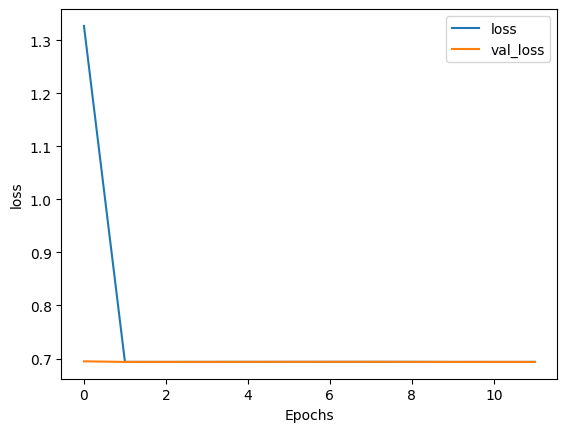

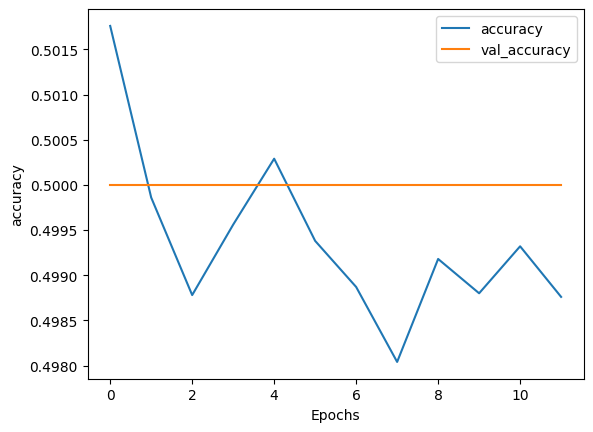

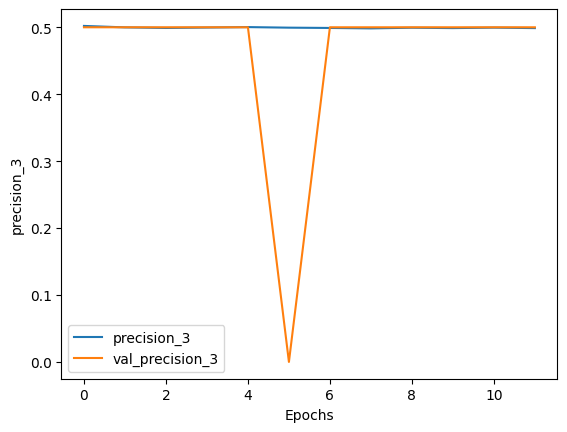

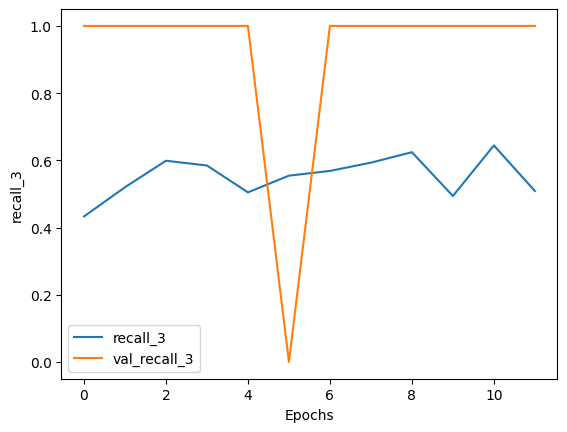

In [39]:
# Plot error rates and metric rates
plot_metrics(MobileNet_model_history, 'loss')
plot_metrics(MobileNet_model_history, 'accuracy')
plot_metrics(MobileNet_model_history, 'precision_3')
plot_metrics(MobileNet_model_history, 'recall_3')

In [40]:
# Save the MobileNet model
MobileNet_model.save("MobileNet_model.h5")

The model with EfficientNet as the base is the clear winner with an accuracy of 97.29%;

In [45]:
# Ensure TensorFlow version compatibility
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [2]:
import tensorflow as tf


In [8]:
model = tf.keras.models.load_model('EfficientNet_model.h5')

In [9]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                1644